All previous .npz files deleted.
                                                                                                    0  \
title                                                                                                   
I left youtube for a month and THIS is what hap...     We stole an ENEMY LOADOUT then this happened..   
TAXI CAB SLAYER KILLS 'TO KNOW HOW IT FEELS'                               나지막이 (리노) Limbo (Lee Know)   
Apex Legends | Stories from the Outlands – “The...                 ASH is INSANELY OP in Apex Legends   
Nines - Clout (Official Video)                               Clavish - No Difference (Official Video)   
i don't know what im doing anymore                  She's blind. I'm blindfolded. We're going to f...   
CGP Grey was WRONG                                  Choose WRONG & The DOPPLEGANGERS Kill Me - Tha...   
Kya Baat Aa : Karan Aujla (Official Video) Tani...  Badshah X Karan Aujla - God Damn (Official Vid...   
I ASKED HER TO BE MY G

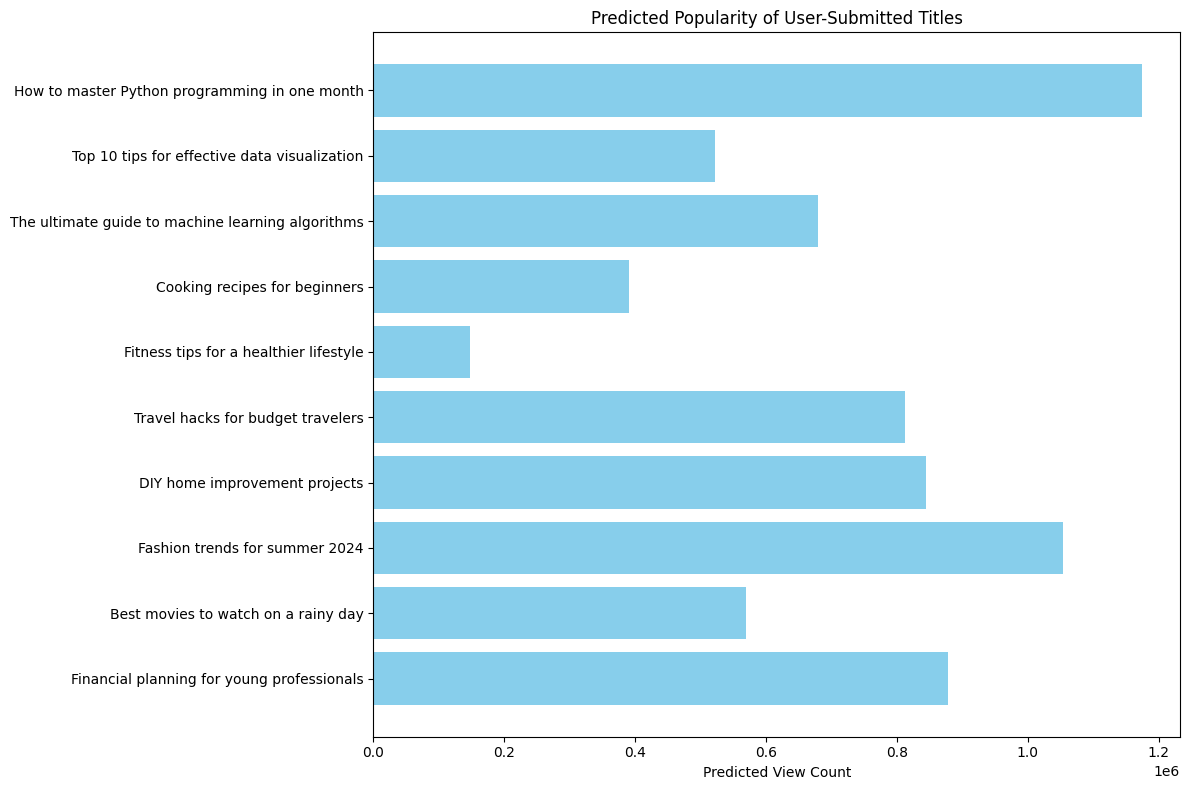

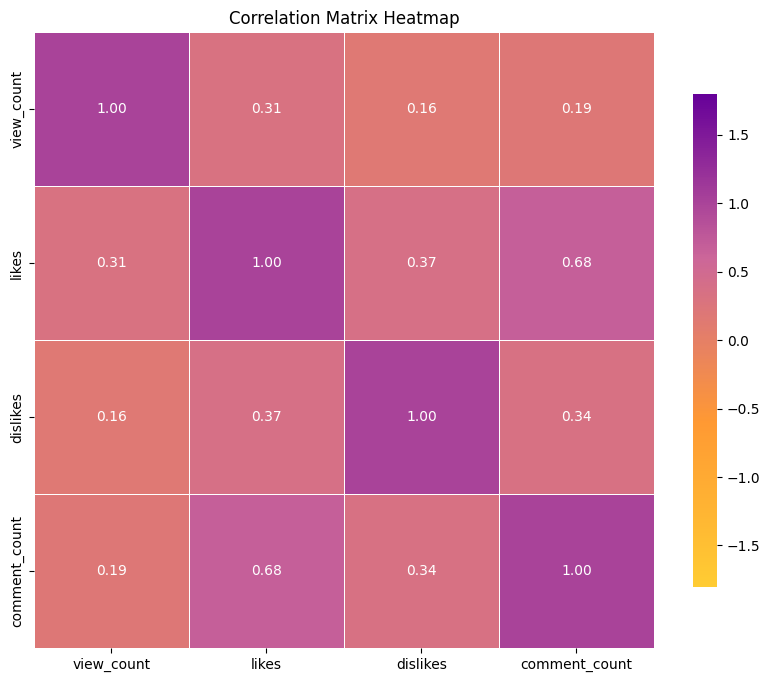

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import save_npz, load_npz, csr_matrix, vstack

# Cleanup previous files on C drive
previous_output_dir = 'C:/path_to_previous_output_directory'

# Get a list of all .npz files in the directory
npz_files = glob.glob(os.path.join(previous_output_dir, '*.npz'))

# Delete each file
for file in npz_files:
    try:
        os.remove(file)
        print(f"Deleted {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

print("All previous .npz files deleted.")

# Ensure the new output directory exists
output_dir = 'E:/youtube_cosine_sim'
os.makedirs(output_dir, exist_ok=True)

# Download NLTK stopwords (uncomment if not already downloaded)
# nltk.download('stopwords')

# Load the dataset (adjust the path accordingly)
df = pd.read_csv('GB_youtube_trending_data.csv')

# Clean and preprocess the dataset
df.drop_duplicates(subset=['video_id'], inplace=True)
if 'description' in df.columns:
    df.dropna(subset=['description'], inplace=True)

if 'publishedAt' in df.columns:
    df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
if 'trending_date' in df.columns:
    df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')

str_columns = ['title', 'channelTitle', 'tags', 'description']
for col in str_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if 'comments_disabled' in df.columns:
    df['comments_disabled'] = df['comments_disabled'].astype(bool)
if 'ratings_disabled' in df.columns:
    df['ratings_disabled'] = df['ratings_disabled'].astype(bool)

# Save cleaned DataFrame to CSV (optional)
df.to_csv('cleaned_GB_youtube_trending_data.csv', index=False)

# Preprocess titles for similarity analysis
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_title'] = df['title'].apply(preprocess_text)

# Compute TF-IDF matrix with limited features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limit the number of features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_title'])

# Use sparse matrix
tfidf_matrix = csr_matrix(tfidf_matrix)

# Compute truncated SVD on TF-IDF matrix
svd = TruncatedSVD(n_components=100)  # Further reduce dimensions
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Clear memory
del tfidf_matrix

# Batch processing for cosine similarity
batch_size = 1000  # Adjust batch size as needed
num_samples = tfidf_matrix_reduced.shape[0]
top_n = 10  # Number of top similar items to store

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    cosine_sim_batch = cosine_similarity(tfidf_matrix_reduced[start:end, :], tfidf_matrix_reduced)
    
    # Only keep top N similarities for each item
    top_similarities = np.zeros((end - start, top_n))
    top_indices = np.zeros((end - start, top_n), dtype=int)
    for i in range(end - start):
        top_n_indices = np.argsort(cosine_sim_batch[i])[-top_n:]
        top_indices[i] = top_n_indices
        top_similarities[i] = cosine_sim_batch[i, top_n_indices]

    np.savez(f'{output_dir}/cosine_sim_top_{start}_{end}.npz', top_similarities=top_similarities, top_indices=top_indices)

# Load all top similarities and concatenate
all_similarities = []
all_indices = []
for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    data = np.load(f'{output_dir}/cosine_sim_top_{start}_{end}.npz')
    all_similarities.append(data['top_similarities'])
    all_indices.append(data['top_indices'])

all_similarities = np.vstack(all_similarities)
all_indices = np.vstack(all_indices)

# Create DataFrame to display similarity scores
similarity_df = pd.DataFrame(index=df['title'], columns=range(top_n))

for i, title in enumerate(df['title']):
    similar_titles = df['title'].iloc[all_indices[i]].values
    similarity_df.iloc[i] = similar_titles

# Display a subset of the similarity matrix
print(similarity_df.head(10))  # Display top 10x10 part of the similarity matrix

# Example: Find most similar titles to the first title in the DataFrame
first_title = df['title'].iloc[0]
similar_titles = similarity_df.iloc[0]
print(f"\nMost similar titles to '{first_title}':")
print(similar_titles.head(10))

# Function to find similar titles and their view counts
def predict_view_count(user_titles, df, tfidf_vectorizer, svd, similarity_df):
    predicted_view_counts = []
    
    for user_title in user_titles:
        user_title_processed = preprocess_text(user_title)
        user_title_tfidf = tfidf_vectorizer.transform([user_title_processed])
        
        # Transform using SVD
        user_title_reduced = svd.transform(user_title_tfidf)
        
        # Compute cosine similarities
        similarities = cosine_similarity(user_title_reduced, tfidf_matrix_reduced)
        similar_indices = np.argsort(similarities[0])[::-1][:10]  # Top 10 similar titles
        
        # Retrieve view counts of similar titles
        similar_view_counts = df.iloc[similar_indices]['view_count']
        
        # Calculate predicted view count
        predicted_view_count = similar_view_counts.mean()
        predicted_view_counts.append(predicted_view_count)
    
    return predicted_view_counts

# Example user-submitted titles
user_titles = [
    "How to master Python programming in one month",
    "Top 10 tips for effective data visualization",
    "The ultimate guide to machine learning algorithms",
    "Cooking recipes for beginners",
    "Fitness tips for a healthier lifestyle",
    "Travel hacks for budget travelers",
    "DIY home improvement projects",
    "Fashion trends for summer 2024",
    "Best movies to watch on a rainy day",
    "Financial planning for young professionals"
]

# Predict view counts for user-submitted titles
predicted_view_counts = predict_view_count(user_titles, df, tfidf_vectorizer, svd, similarity_df)

# Plotting the predicted view counts
plt.figure(figsize=(12, 8))
plt.barh(user_titles, predicted_view_counts, color='skyblue')
plt.xlabel('Predicted View Count')
plt.title('Predicted Popularity of User-Submitted Titles')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest prediction at the top
plt.tight_layout()
plt.show()

# Visualize correlation matrix of numeric columns
numeric_df = df[['view_count', 'likes', 'dislikes', 'comment_count']]
correlation_matrix = numeric_df.corr()

colors = ["#FFCC33", "#FF9933", "#CC6699", "#660099"]
cmap = LinearSegmentedColormap.from_list("sunset_deep_purple", colors)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=cmap, cbar_kws={"shrink": .8}, linewidths=.5,
            vmin=-1.8, vmax=1.8)
plt.title('Correlation Matrix Heatmap')
plt.show()
